<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/Unstructured_Data_Analysis_For_BigQuery_ML_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BQML pipeline for unstructured image data using SQL
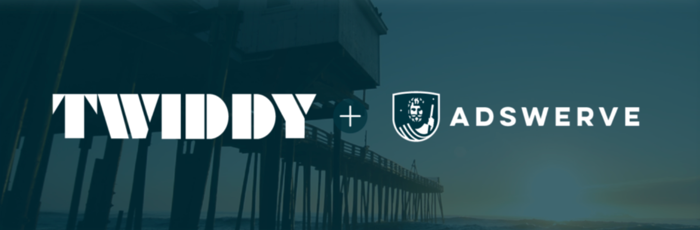

# Demo Summary
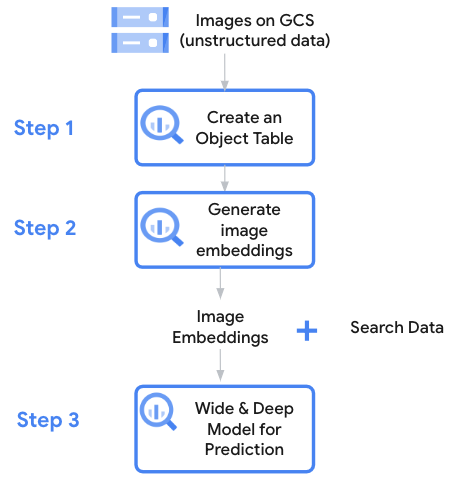

# Toy Example



In [1]:
#@markdown Authenticate
from google.colab import auth
auth.authenticate_user()
from google.cloud.bigquery import magics
project_id='your-project-here' #@param {type:"string"}
bucket_id='your-bucket-id' #@param {type:"string"}
magics.context.project = project_id

## Load images to GCS bucket
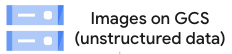

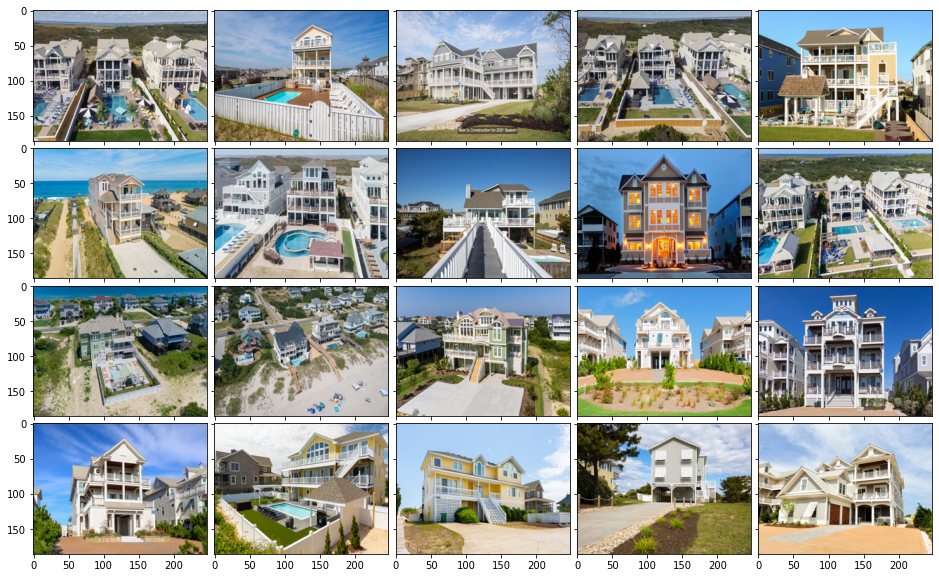

In [3]:
#@markdown Load the example images into bucket and preview

#@markdown `$ gsutil cp /cdn/www/images/*.jpg gs://demo/images`
!rm -rf images
!mkdir images
!gsutil -mq cp gs://$bucket_id/images/* ./images/
!gsutil -mq cp gs://$bucket_id/featured/* ./images/
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(img):
    img = Image.open('./images/'+img).convert('RGB')
    img = img.resize((248,186))
    img = np.asarray(img)
    return img
images = os.listdir('./images')
img_arr = []

for image in images:
    img_arr.append(img_reshape(image))
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

## Create BigLake connection to image bucket
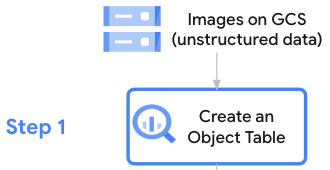

### Create Connection, get the SA and grant IAM `objectViewer` to bucket

In [ ]:
!bq mk --connection --location=US --project_id=$project_id --connection_type=CLOUD_RESOURCE demo-images

In [ ]:
!bq show --location=US --project_id=$project_id --connection  demo-images

In [ ]:
#@markdown `$ gsutil iam ch serviceAccount:<replace with SA>:objectViewer "gs://bucket"`
sa = "your-connection-sa-here@gcp-sa-bigquery-condel.iam.gserviceaccount.com"
!gsutil iam ch serviceAccount:$sa:objectViewer "gs://$bucket_id"

### Create External Object Table

In [32]:
# you can connect your object table to multiple buckets, folders
param = {"bucket_uris": eval('["gs://{0}/images/*","gs://{0}/featured/*"]'.format(bucket_id))}

In [33]:
%%bigquery --params $param
CREATE OR REPLACE EXTERNAL TABLE `sandbox.demo_images`
WITH CONNECTION `us.demo-images` 
OPTIONS(
  object_metadata="DIRECTORY", uris=@bucket_uris);

Empty DataFrame
Columns: []
Index: []

### Query new Object Table

In [34]:
%%bigquery
SELECT uri, content_type, size
FROM `sandbox.demo_images`
LIMIT 10

uri content_type     size
0   gs://as-bqml-launch-demo/images/B800-rearext.jpg   image/jpeg   338409
1  gs://as-bqml-launch-demo/images/ER008-aerialre...   image/jpeg  1817843
2  gs://as-bqml-launch-demo/images/ER010-aerialre...   image/jpeg  1940969
3  gs://as-bqml-launch-demo/images/ER011-aerialre...   image/jpeg  1949278
4  gs://as-bqml-launch-demo/images/J10975-aerial-...   image/jpeg  1606464
5  gs://as-bqml-launch-demo/images/J20944-aerialr...   image/jpeg  1966214
6  gs://as-bqml-launch-demo/images/KD1111-rearext...   image/jpeg  1508587
7  gs://as-bqml-launch-demo/images/KD1301-rearext...   image/jpeg  1407560
8   gs://as-bqml-launch-demo/images/b372-rearext.jpg   image/jpeg  1841978
9  gs://as-bqml-launch-demo/images/ec3-aerialrear...   image/jpeg  1572170

In [35]:
!gsutil ls gs://$bucket_id/images

gs://as-bqml-launch-demo/images/
gs://as-bqml-launch-demo/images/B800-rearext.jpg
gs://as-bqml-launch-demo/images/ER008-aerialrearext.jpg
gs://as-bqml-launch-demo/images/ER010-aerialrearext.jpg
gs://as-bqml-launch-demo/images/ER011-aerialrearext.jpg
gs://as-bqml-launch-demo/images/J10975-aerial-2.jpg
gs://as-bqml-launch-demo/images/J20944-aerialrearext.jpg
gs://as-bqml-launch-demo/images/KD1111-rearext.jpg
gs://as-bqml-launch-demo/images/KD1301-rearext.jpg
gs://as-bqml-launch-demo/images/b372-rearext.jpg
gs://as-bqml-launch-demo/images/ec3-aerialrearext.jpg


In [36]:
%%bigquery df
select data from `sandbox.demo_images`
WHERE REGEXP_CONTAINS(uri, '(b|B)800-.*')
LIMIT 2

In [37]:
df

data
0  b'\xff\xd8\xff\xe1\x16<Exif\x00\x00II*\x00\x08...
1  b'\xff\xd8\xff\xe1\x1d\x91Exif\x00\x00II*\x00\...

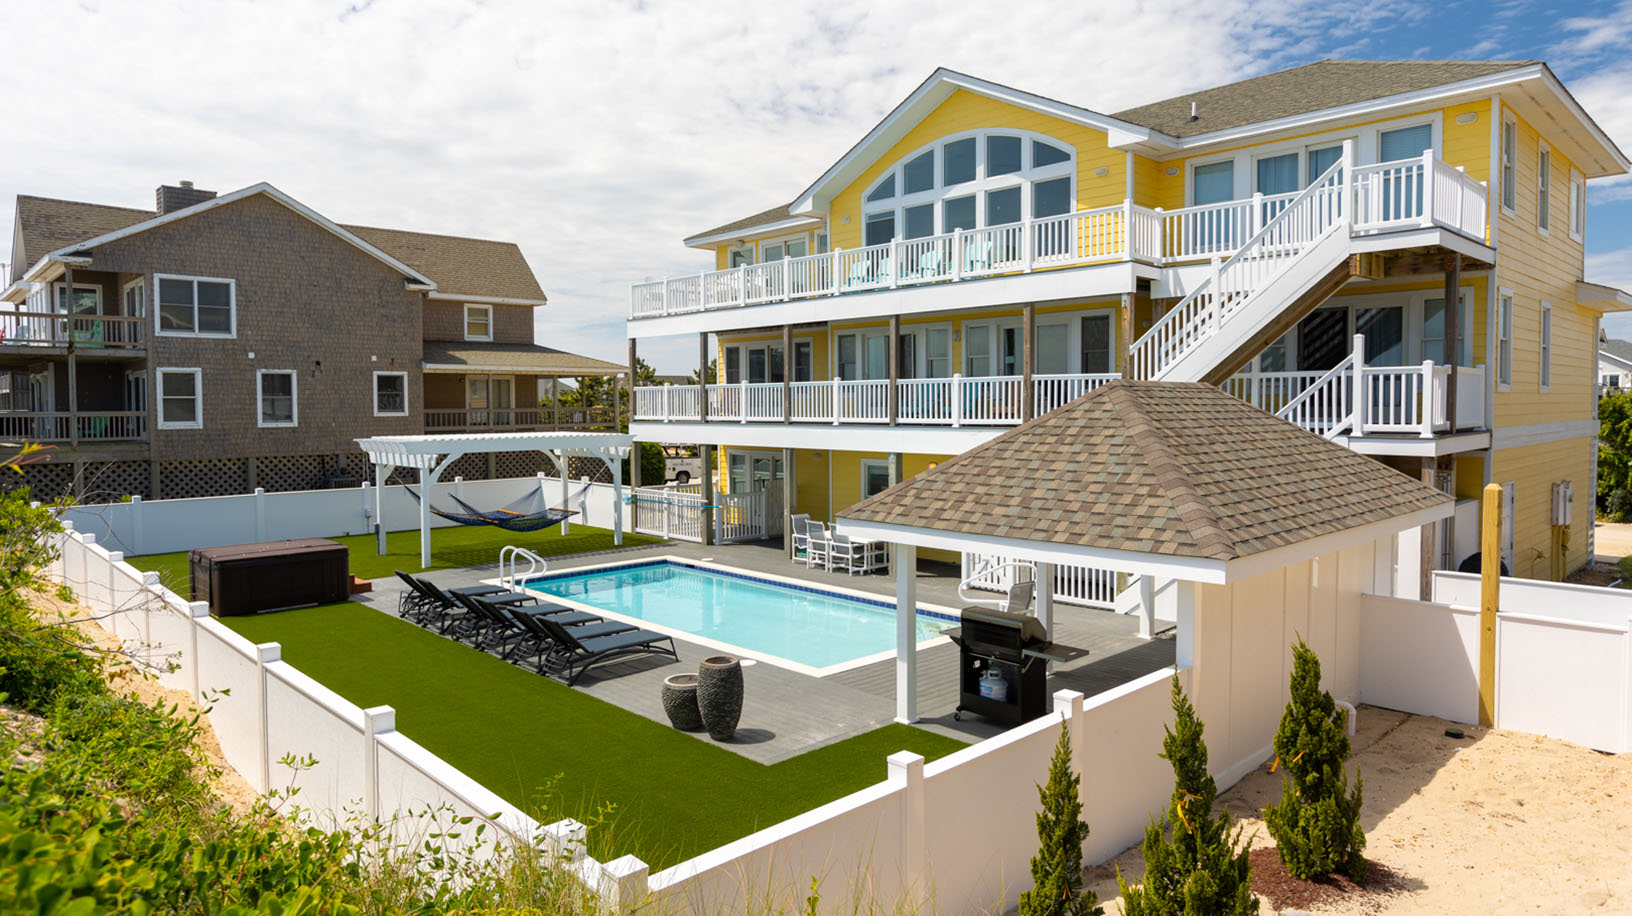

(1632, 916)

In [38]:
from IPython.display import display
from PIL import Image
import io
image = Image.open(io.BytesIO(df.data[1]))
display(image)
image.size

## Create custom TensorFlow image models
*  ResNet 50 Classification ([tfhub.dev link](https://tfhub.dev/tensorflow/resnet_50/classification/1))
*  ResNet 50 Feature Vectors ([tfhub.dev link](https://tfhub.dev/tensorflow/resnet_50/feature_vector/1))

In [40]:
#@markdown Download models and untar them locally

#@markdown \**Transfer learning* to adapt SotA model to business domain\* goes here  

#@markdown `$ wget -c tfhub.dev/resnet50_etc ...` 
!rm -rf ./*
!mkdir classification
!mkdir feature_vecs
!wget -cq https://tfhub.dev/tensorflow/resnet_50/classification/1?tf-hub-format=compressed -O classification.tar.gz
!wget -cq https://tfhub.dev/tensorflow/resnet_50/feature_vector/1?tf-hub-format=compressed -O feature_vecs.tar.gz

!tar -xf classification.tar.gz --directory classification
!tar -xf feature_vecs.tar.gz --directory feature_vecs

!ls -lh

total 175M
drwxr-xr-t 3 root root 4.0K Oct 24  2019 classification
-rw-r--r-- 1 root root  92M Oct 24  2019 classification.tar.gz
drwxr-xr-t 3 root root 4.0K Oct 24  2019 feature_vecs
-rw-r--r-- 1 root root  84M Oct 24  2019 feature_vecs.tar.gz


## Load models in GCS bucket

In [41]:
#@markdown `$ gsutil cp -r ./model_path/ gs://bucket/` ... 

!gsutil -mq rm -rf gs://$bucket_id/models/
!gsutil -m cp -r ./classification/ gs://$bucket_id/models/
!gsutil -m cp -r ./feature_vecs/ gs://$bucket_id/models/

CommandException: 1 files/objects could not be removed.
Copying file://./classification/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./classification/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./classification/variables/variables.index [Content-Type=application/octet-stream]...
| [3/3 files][102.5 MiB/102.5 MiB] 100% Done                                    
Operation completed over 3 objects/102.5 MiB.                                    
Copying file://./feature_vecs/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./feature_vecs/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./feature_vecs/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [3/3 files][ 94.6 MiB/ 94.6 MiB] 100% Done                                    
Operation completed over 3 objects/94.6 MiB.                                     


## Create models in BQ
Use `CREATE MODEL` with OPTIONS `model_type="TENSORFLOW"` to mount to bucket path

In [42]:
param = { 
    "model_class_path": "gs://{}/models/classification/*".format(bucket_id),
    "model_vector_path": "gs://{}/models/feature_vecs/*".format(bucket_id)
}

In [43]:
%%bigquery --params $param
CREATE OR REPLACE MODEL `sandbox.resnet50_1k_class`
OPTIONS(
 model_type="TENSORFLOW",
 color_space="RGB",
 model_path=@model_class_path)

Empty DataFrame
Columns: []
Index: []

In [44]:
%%bigquery --params $param
CREATE OR REPLACE MODEL `sandbox.resnet50_1k_ftvec`
OPTIONS(
 model_type="TENSORFLOW",
 color_space="RGB",
 model_path=@model_vector_path)

Empty DataFrame
Columns: []
Index: []

## Generate Image Labels, Embeddings
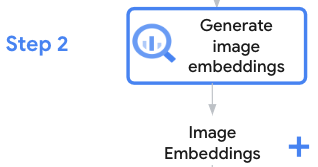

In [45]:
#@markdown Grab the ImageNet 1k labels, should return 1000 labels

#@markdown link: http://download.tensorflow.org/data/ImageNetLabels.txt
import urllib.request
label_arr = []
for line in urllib.request.urlopen('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt', ):
    label_arr.append(line.decode('utf-8').replace("\n", ""))
_header = label_arr.pop(0)
params = {'labels': label_arr}
len(label_arr)

1000

In [46]:
%%bigquery --params $params
DECLARE labels ARRAY<STRING> DEFAULT @labels;
with predictions as (
  SELECT 
    SPLIT(uri, "/")[SAFE_OFFSET(ARRAY_LENGTH(SPLIT(uri, "/")) - 1)] as img_name,
    labels[SAFE_OFFSET(i)] as label,
    score
  FROM ML.PREDICT(
      MODEL `bqml-customer-launch.sandbox.resnet50_1k_class`, 
      (
        SELECT * FROM `bqml-customer-launch.sandbox.demo_images` # replace with your project
        WHERE REGEXP_CONTAINS(uri, '(b|B)800-.*')                # for this demo only
        LIMIT 2
      )
  ), UNNEST(activation_49) as score WITH OFFSET i                # replace with your model layer
)
SELECT * FROM predictions
ORDER BY img_name, score DESC
LIMIT 3;

img_name        label     score
0      b800-Ext.jpg       palace  0.436047
1      b800-Ext.jpg  mobile home  0.141396
2      b800-Ext.jpg        patio  0.133754
3  B800-rearext.jpg    boathouse  0.272735
4  B800-rearext.jpg      library  0.270167
5  B800-rearext.jpg        patio  0.191964

# ML Pipeline in SQL

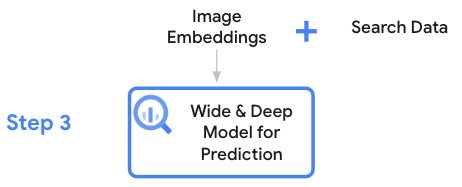

In [ ]:
%%bigquery
CREATE OR REPLACE PROCEDURE `pipeline.run_pipeline`
  (DateStart STRING, DateEnd STRING, mode STRING, NumImages INT64)
BEGIN
  -- ┌───────────────────┐┌───────────────────┐┌───────────────────────┐
  -- │collect_search_data││create_image_labels││create_image_embeddings│
  -- └┬──────────────────┘└─┬─────────────────┘└┬──────────────────────┘
  -- ┌▽────────────────────┐│┌──────────────────▽───────────────┐       
  -- │create_search_context│││embedding_dimensionality_reduction│       
  -- └┬────────────────────┘│└┬─────────────────────────────────┘       
  -- ┌▽─────────────────────▽┐│                                         
  -- │image_data             ││                                         
  -- └┬──────────────────────┘│                                         
  -- ┌▽───────────────────────▽┐                                        
  -- │stratify_and_shuffle     │                                        
  -- └┬────────────────────────┘                                        
  -- ┌▽──────────┐                                                      
  -- │train_model│                                                      
  -- └───────────┘  
  
  if mode="TRAIN" THEN
      CALL pipeline.collect_search_data(DateStart,DateEnd,mode);
      CALL pipeline.create_search_context(mode);
      CALL pipeline.get_image_data(mode);
      CALL pipeline.embedding_dimensionality_reduction();--training PCA not needed for predict
      CALL pipeline.stratify_and_shuffle(NumImages,mode);
      CALL pipeline.train_model();
  ELSE
      CALL pipeline.collect_search_data(DateStart,DateEnd,mode);
      CALL pipeline.create_search_context(mode);
      CALL pipeline.get_image_data(mode);
      CALL pipeline.predict_and_explain();
  END IF;
END

## `ML.GLOBAL_EXPLAIN()` to understand your model weights

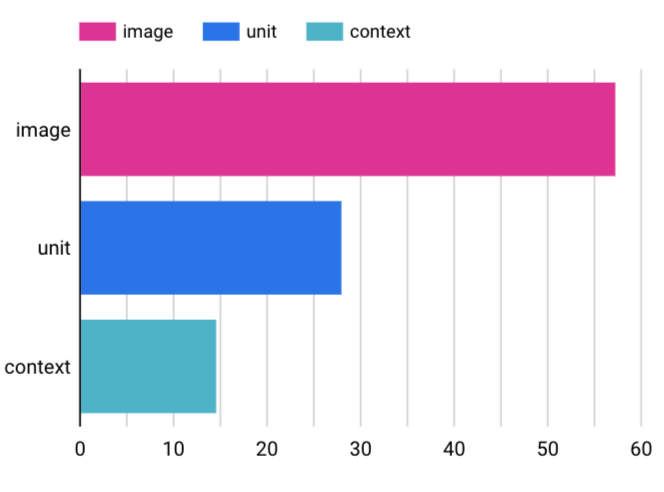

# Production!

In [47]:
%%bigquery df_predictions
select    
  predicted_clicked,
  (SELECT prob FROM unnest(predicted_clicked_probs) WHERE label = 1) as prob,
  * except(predicted_clicked_probs, predicted_clicked)
FROM ML.PREDICT(MODEL `pipeline.wide_and_deep`, (            # replace with your model
    select * except(clicked)
    from `sandbox.demo_image_and_search`                     # replace with your input data
  )
)

In [48]:
#@markdown A/B Seed List: `sort=1` is the control, treatment is `MAX(prob) where sort!=1` 
df_predictions.groupby(by=['name','img_name','sort']) \
  .agg({'prob':'mean'}) \
  .sort_values(by=['name','sort'])

prob
name                    img_name                 sort          
Aqua Dream              J10975-ext-banner.jpg    1     0.722776
                        J10975-aerial-2.jpg      3     0.774948
Atlantis                KD1111-nightext2.jpg     1     0.740830
                        KD1111-rearext.jpg       2     0.788307
Creme de la Creme       J20944-aerialext.jpg     1     0.542511
                        J20944-aerialrearext.jpg 2     0.690670
Heavens to Betsy        ER011-ext.jpg            1     0.799610
                        ER011-aerialrearext.jpg  2     0.825732
Mariner's Compass       ER008-ext.jpg            1     0.542999
                        ER008-aerialrearext.jpg  2     0.741982
SEAesta                 KD1301-aerialext.jpg     1     0.621062
                        KD1301-rearext.jpg       2     0.691429
Salty Paws              b800-Ext.jpg             1     0.474145
                        B800-rearext.jpg         2     0.703364
Sound to Sea Beach Club EC3-ext.jpg              1     0.775320
                        ec3-aerialrearext.jpg    4     0.781681
The Ocean Club of OBX   er010-ext.jpg            1     0.594581
                        ER010-aerialrearext.jpg  2     0.732314
Time to Beach           b372-ext.jpg             1     0.472073
                        b372-rearext.jpg         2     0.691180